<h1> Imports

In [319]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import nltk
import os
import random

In [320]:
# !pip install torchtext==0.10.0 --user

In [321]:
# !pip install torch==1.11.0 torchtext==0.12.0 --user

In [322]:
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

<h1>Import Data

In [323]:
max_words = 25

In [324]:
data = pd.read_csv('../Data/news-article-categories-clean.csv')

<h1> Vocabulary

In [325]:
tokenizer = get_tokenizer("basic_english")

data['tok_body'] = data.body.apply(lambda x: tokenizer(x))

vocab = build_vocab_from_iterator(data['tok_body'], min_freq=1, specials=["<UNK>"])

vocab.set_default_index(vocab["<UNK>"])

len(vocab)

66936

<h1> Tokenization

In [326]:
data["cat"] = pd.Categorical(data.category)
data['cat_code'] = data.cat.cat.codes

In [327]:
data["body_tok"] = data["body"].apply(lambda x: vocab(tokenizer(x)))

In [328]:
data["body_max_len"] = data["body_tok"].apply(lambda x: x+([0]* (max_words-len(x))) if len(x)<max_words else x[:max_words])

In [329]:
#Dropping rows of the biggest category so the RNN doesn't overfit
data = data.drop(range(0, 500), axis = 0)
data.reset_index(drop=True, inplace=True)

In [330]:
data_sans_na = data.dropna()
data_sans_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6371 entries, 0 to 6370
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   category      6371 non-null   object  
 1   title         6371 non-null   object  
 2   body          6371 non-null   object  
 3   tok_body      6371 non-null   object  
 4   cat           6371 non-null   category
 5   cat_code      6371 non-null   int8    
 6   body_tok      6371 non-null   object  
 7   body_max_len  6371 non-null   object  
dtypes: category(1), int8(1), object(6)
memory usage: 311.9+ KB


<h1>Target Classes

In [331]:
target_classes = ["ART & CULTURE","BUSINESS","COMEDY","CRIME","EDUCATION","ENTERTAINMENT","ENVIRONMENT","MEDIA","POLITICS","RELIGION","SCIENCE","SPORTS","TECH","WOMEN"]
# target_classes = ["BUSINESS","COMEDY","CRIME","EDUCATION","ENTERTAINMENT","ENVIRONMENT","MEDIA","POLITICS","RELIGION","SCIENCE","SPORTS","TECH","WOMEN"]

In [332]:
len(target_classes)

14

In [333]:
target_classes_int = [i for i in range(14)]

<h1>Train / Test Split

In [334]:
X = data_sans_na.drop(["category", "cat_code", "cat"], axis =1)
y = data_sans_na["cat_code"]

In [335]:
X.head()

,title,body,tok_body,body_tok,body_max_len
0,"John Williams Has Never Seen 'Star Wars,' Does...",musical composition simply destined live forev...,"[musical, composition, simply, destined, live,...","[958, 3831, 511, 11952, 195, 2014, 724, 408, 6...","[958, 3831, 511, 11952, 195, 2014, 724, 408, 6..."
1,"An Alert, Well-Hydrated Artist in No Acute Dis...",serial two artist incurable neurological disea...,"[serial, two, artist, incurable, neurological,...","[3155, 28, 106, 26752, 10908, 1361, 1230, 481,...","[3155, 28, 106, 26752, 10908, 1361, 1230, 481,..."
2,Stage Door: Ute Lemper's Songs From The Broken...,ute lemper acclaimed german chanteuse bares co...,"[ute, lemper, acclaimed, german, chanteuse, ba...","[41585, 24026, 4984, 2130, 34756, 43671, 10456...","[41585, 24026, 4984, 2130, 34756, 43671, 10456..."
3,Donna Quesada: Art Review,dear friend larry payne mentioned purchased th...,"[dear, friend, larry, payne, mentioned, purcha...","[2410, 133, 1409, 8487, 2248, 3461, 101, 7306,...","[2410, 133, 1409, 8487, 2248, 3461, 101, 7306,..."
4,Top 5 Sizzling Hot Winter Music Festivals in F...,andrew cyrille photo petra cvelbar thelonious ...,"[andrew, cyrille, photo, petra, cvelbar, thelo...","[2040, 35217, 170, 9271, 46730, 13211, 5778, 1...","[2040, 35217, 170, 9271, 46730, 13211, 5778, 1..."


In [336]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: cat_code, dtype: int8

In [337]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [338]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

<h1> Vectorize Batch

In [339]:
def vectorize_batch(batch):
    Y = tuple(map(lambda x: x["label"], batch))
    X = tuple(map(lambda x: x["text"], batch))
    X_t = torch.tensor(X,dtype=torch.long)
    Y_t = torch.tensor(Y, dtype=torch.long)
    return X_t, Y_t 
   

<h1> Load Data

In [340]:
# Définir une classe pour transformer un Dataframe en Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['body_max_len']
        label = row['cat_code']
        return {'label': label, 'text': text}

# Créer une instance de la classe Dataset personnalisée
train_dataset = CustomDataset(train)
test_dataset = CustomDataset(test)

train_dataset, test_dataset  = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [341]:
train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn= vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=vectorize_batch)

In [342]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 25]) torch.Size([1024])


<h1> RNN

In [343]:
#Paramètres du modèle
EMBED_LEN = 500
HIDDEN_SIZE1 = 500
HIDDEN_SIZE2 = 150
HIDDEN_SIZE3 = 200
OUTPUT_SIZE = len(target_classes)
N_LAYERS = 5

In [344]:
#Classe pour le modèle RNN simple
class RNNClassifier1(nn.Module):
    def __init__(self):
        super(RNNClassifier1, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
        self.rnn = nn.RNN(input_size=EMBED_LEN, hidden_size=HIDDEN_SIZE1, num_layers=N_LAYERS, batch_first=True)
        self.linear = nn.Linear(HIDDEN_SIZE1, OUTPUT_SIZE)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE1))
        return self.linear(output[:,-1])

In [345]:
#Classe pour le modèle a multiple RNN 
class RNNClassifier2(nn.Module):
    def __init__(self):
        super(RNNClassifier2, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
        self.rnn1 = nn.RNN(input_size=EMBED_LEN, hidden_size=HIDDEN_SIZE1, num_layers=N_LAYERS, batch_first=True)
        self.rnn2 = nn.RNN(input_size=HIDDEN_SIZE1, hidden_size=HIDDEN_SIZE2, num_layers=N_LAYERS, batch_first=True)
        self.rnn3 = nn.RNN(input_size=HIDDEN_SIZE2, hidden_size=HIDDEN_SIZE3, num_layers=N_LAYERS, batch_first=True)
        self.linear = nn.Linear(HIDDEN_SIZE3, OUTPUT_SIZE)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn1(embeddings, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE1))
        output, hidden = self.rnn2(output, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE2))
        output, hidden = self.rnn3(output, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE3))
        return self.linear(output[:,-1])

In [346]:
rnn_classifier1 = RNNClassifier1()

rnn_classifier1

RNNClassifier1(
  (embedding_layer): Embedding(66936, 500)
  (rnn): RNN(500, 500, num_layers=5, batch_first=True)
  (linear): Linear(in_features=500, out_features=14, bias=True)
)

In [347]:
rnn_classifier2 = RNNClassifier2()

rnn_classifier2

RNNClassifier2(
  (embedding_layer): Embedding(66936, 500)
  (rnn1): RNN(500, 500, num_layers=5, batch_first=True)
  (rnn2): RNN(500, 150, num_layers=5, batch_first=True)
  (rnn3): RNN(150, 200, num_layers=5, batch_first=True)
  (linear): Linear(in_features=200, out_features=14, bias=True)
)

In [348]:
for layer in rnn_classifier1.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(66936, 500)
Parameters : 
torch.Size([66936, 500])

Layer : RNN(500, 500, num_layers=5, batch_first=True)
Parameters : 
torch.Size([500, 500])
torch.Size([500, 500])
torch.Size([500])
torch.Size([500])
torch.Size([500, 500])
torch.Size([500, 500])
torch.Size([500])
torch.Size([500])
torch.Size([500, 500])
torch.Size([500, 500])
torch.Size([500])
torch.Size([500])
torch.Size([500, 500])
torch.Size([500, 500])
torch.Size([500])
torch.Size([500])
torch.Size([500, 500])
torch.Size([500, 500])
torch.Size([500])
torch.Size([500])

Layer : Linear(in_features=500, out_features=14, bias=True)
Parameters : 
torch.Size([14, 500])
torch.Size([14])



In [349]:
out = rnn_classifier1(torch.randint(0, len(vocab), (1024, max_words)))

out.shape

torch.Size([1024, 14])

In [350]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def calc_val_loss_and_accuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        calc_val_loss_and_accuracy(model, loss_fn, val_loader)

<h1> Entrainement Single RNN

In [351]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier1()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

In [352]:
train_model(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 5/5 [00:17<00:00,  3.55s/it]


Train Loss : 2.614
Valid Loss : 2.521
Valid Acc  : 0.161


100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


Train Loss : 2.165
Valid Loss : 2.508
Valid Acc  : 0.195


100%|██████████| 5/5 [00:16<00:00,  3.39s/it]


Train Loss : 1.635
Valid Loss : 2.623
Valid Acc  : 0.220


100%|██████████| 5/5 [00:17<00:00,  3.42s/it]


Train Loss : 1.035
Valid Loss : 2.866
Valid Acc  : 0.225


100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


Train Loss : 0.544
Valid Loss : 3.174
Valid Acc  : 0.253


100%|██████████| 5/5 [00:17<00:00,  3.44s/it]


Train Loss : 0.229
Valid Loss : 3.496
Valid Acc  : 0.238


100%|██████████| 5/5 [00:17<00:00,  3.41s/it]


Train Loss : 0.093
Valid Loss : 3.888
Valid Acc  : 0.220


100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


Train Loss : 0.045
Valid Loss : 4.010
Valid Acc  : 0.242


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


Train Loss : 0.023
Valid Loss : 4.237
Valid Acc  : 0.246


100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


Train Loss : 0.015
Valid Loss : 4.347
Valid Acc  : 0.253


100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


Train Loss : 0.010
Valid Loss : 4.433
Valid Acc  : 0.249


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Train Loss : 0.007
Valid Loss : 4.487
Valid Acc  : 0.250


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


Train Loss : 0.006
Valid Loss : 4.502
Valid Acc  : 0.250


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


Train Loss : 0.005
Valid Loss : 4.539
Valid Acc  : 0.257


100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


Train Loss : 0.006
Valid Loss : 4.566
Valid Acc  : 0.261


In [353]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(rnn_classifier, test_loader)

In [354]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.2619607843137255

Classification Report : 
               precision    recall  f1-score   support

ART & CULTURE       0.22      0.20      0.21       105
     BUSINESS       0.16      0.22      0.18        90
       COMEDY       0.19      0.24      0.21        62
        CRIME       0.22      0.25      0.24        52
    EDUCATION       0.48      0.35      0.40       106
ENTERTAINMENT       0.24      0.22      0.23        96
  ENVIRONMENT       0.29      0.29      0.29        96
        MEDIA       0.26      0.24      0.25        67
     POLITICS       0.24      0.25      0.25       111
     RELIGION       0.17      0.20      0.19        94
      SCIENCE       0.36      0.23      0.28        87
       SPORTS       0.47      0.44      0.45       117
         TECH       0.24      0.28      0.26        88
        WOMEN       0.20      0.19      0.20       104

     accuracy                           0.26      1275
    macro avg       0.27      0.26      0.26      1275
 w

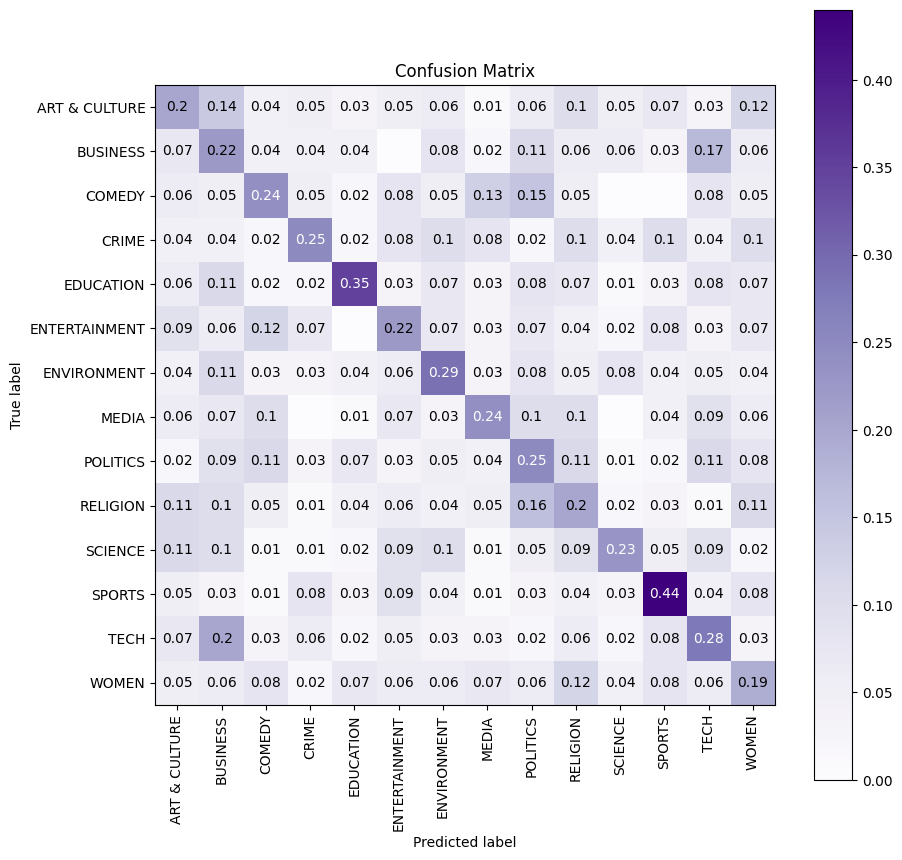

In [355]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(10,10)
                                    );
plt.xticks(rotation=90);

<h1> Entrainement Multi RNN

In [356]:
epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier2()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

In [357]:
train_model(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 5/5 [00:23<00:00,  4.65s/it]


Train Loss : 2.634
Valid Loss : 2.624
Valid Acc  : 0.079


100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


Train Loss : 2.604
Valid Loss : 2.579
Valid Acc  : 0.125


100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


Train Loss : 2.555
Valid Loss : 2.574
Valid Acc  : 0.118


100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


Train Loss : 2.516
Valid Loss : 2.538
Valid Acc  : 0.112


100%|██████████| 5/5 [1:00:33<00:00, 726.69s/it] 


Train Loss : 2.516
Valid Loss : 2.582
Valid Acc  : 0.129


100%|██████████| 5/5 [01:14<00:00, 14.96s/it]


Train Loss : 2.536
Valid Loss : 2.559
Valid Acc  : 0.126


100%|██████████| 5/5 [00:30<00:00,  6.07s/it]


Train Loss : 2.494
Valid Loss : 2.536
Valid Acc  : 0.133


100%|██████████| 5/5 [00:29<00:00,  5.88s/it]


Train Loss : 2.463
Valid Loss : 2.512
Valid Acc  : 0.148


100%|██████████| 5/5 [00:35<00:00,  7.11s/it]


Train Loss : 2.422
Valid Loss : 2.518
Valid Acc  : 0.127


100%|██████████| 5/5 [00:36<00:00,  7.23s/it]


Train Loss : 2.362
Valid Loss : 2.507
Valid Acc  : 0.152


100%|██████████| 5/5 [00:36<00:00,  7.29s/it]


Train Loss : 2.303
Valid Loss : 2.518
Valid Acc  : 0.147


100%|██████████| 5/5 [00:36<00:00,  7.32s/it]


Train Loss : 2.258
Valid Loss : 2.524
Valid Acc  : 0.122


100%|██████████| 5/5 [00:36<00:00,  7.28s/it]


Train Loss : 2.209
Valid Loss : 2.529
Valid Acc  : 0.137


100%|██████████| 5/5 [00:36<00:00,  7.36s/it]


Train Loss : 2.110
Valid Loss : 2.522
Valid Acc  : 0.131


100%|██████████| 5/5 [00:35<00:00,  7.16s/it]


Train Loss : 2.049
Valid Loss : 2.591
Valid Acc  : 0.129


In [358]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.2619607843137255

Classification Report : 
               precision    recall  f1-score   support

ART & CULTURE       0.22      0.20      0.21       105
     BUSINESS       0.16      0.22      0.18        90
       COMEDY       0.19      0.24      0.21        62
        CRIME       0.22      0.25      0.24        52
    EDUCATION       0.48      0.35      0.40       106
ENTERTAINMENT       0.24      0.22      0.23        96
  ENVIRONMENT       0.29      0.29      0.29        96
        MEDIA       0.26      0.24      0.25        67
     POLITICS       0.24      0.25      0.25       111
     RELIGION       0.17      0.20      0.19        94
      SCIENCE       0.36      0.23      0.28        87
       SPORTS       0.47      0.44      0.45       117
         TECH       0.24      0.28      0.26        88
        WOMEN       0.20      0.19      0.20       104

     accuracy                           0.26      1275
    macro avg       0.27      0.26      0.26      1275
 w

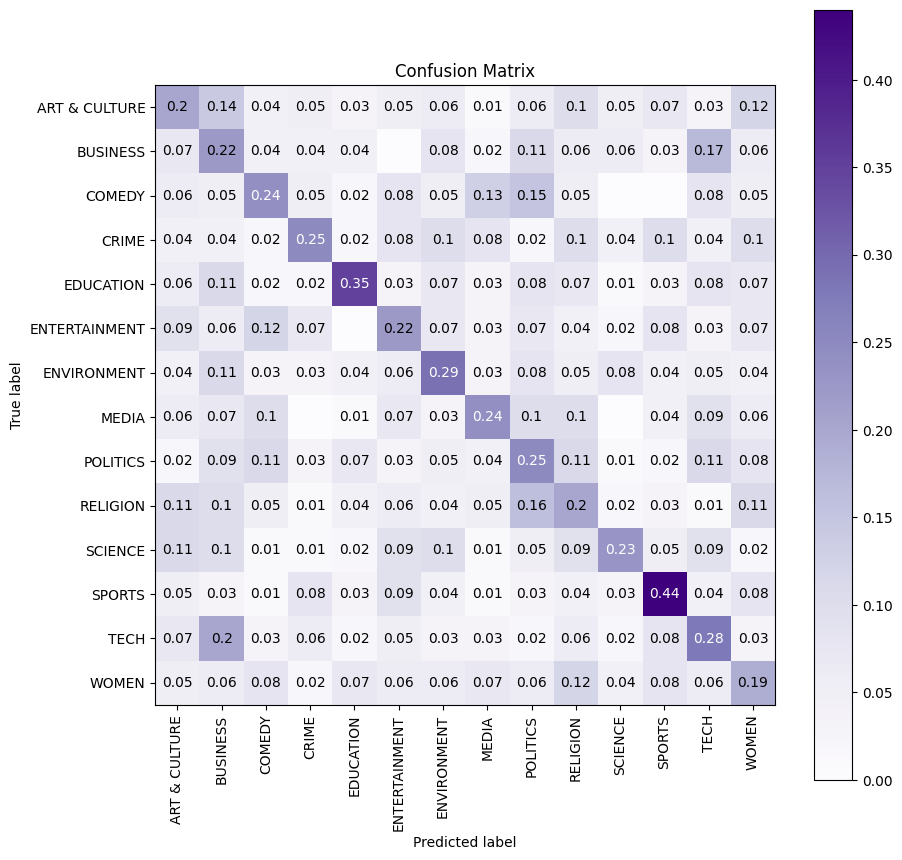

In [359]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(10,10)
                                    );
plt.xticks(rotation=90);